# Visualizing Document Clusters in Corporatus DB

In [4]:
from utils.orientdb import OrientDBClient

orientdb_client = OrientDBClient()
orientdb_client.connect()

query = f"""SELECT @rid.asString() as id, ai_keywords
            FROM Papers
            WHERE processed = True
            AND NOT (ai_keywords = '')"""

result = orientdb_client.execute_query(query)

list_keywords_papers = [record.ai_keywords for record in result]

INFO:utils.orientdb:Connected to database 'berkeley'


In [5]:
print(len(list_keywords_papers))

1989


In [6]:
query = f"""SELECT @rid.asString() as id, ai_keywords
            FROM Papers
            WHERE processed = True"""
all_papers = orientdb_client.execute_query(query)
print(f'{len(all_papers)=}')

len(all_papers)=2086


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd


# Step 1 & 2: Preprocess and feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(list_keywords_papers)

print(tfidf_matrix.shape)

(1989, 13266)


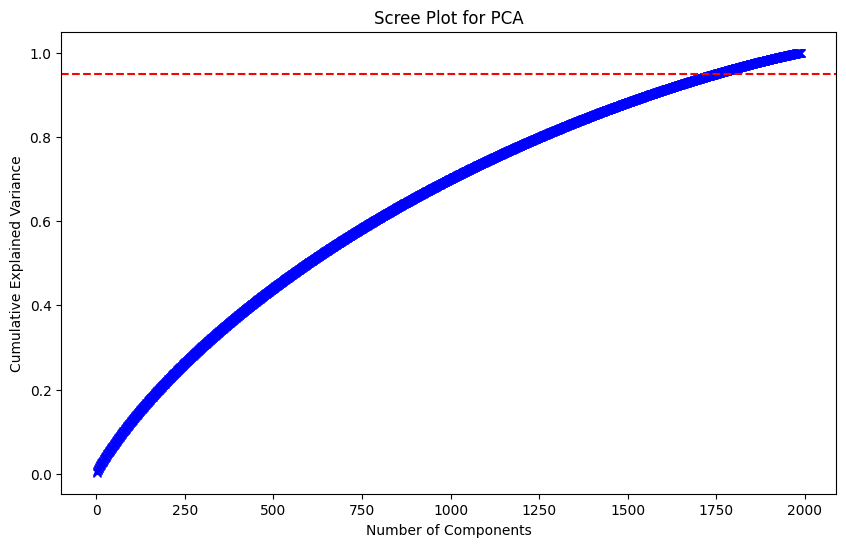

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Run PCA without reducing dimensionality
pca = PCA()
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting the scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bx-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot for PCA')
plt.axhline(y=0.95, color='r', linestyle='--') # Line at 95% variance
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Step 1 & 2: Preprocess and feature extraction using TF-IDF
# Set the maximum number of features to 1300
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1800, max_df=0.95, min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(list_keywords_papers)
print(tfidf_matrix.shape)

(1989, 1800)


/home/tenjin1/alfredo/corporatus/dashboard_db/dashboard-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tenjin1/alfredo/corporatus/dashboard_db/dashboard-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tenjin1/alfredo/corporatus/dashboard_db/dashboard-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/tenjin1/alfredo/corporatus/dashboa

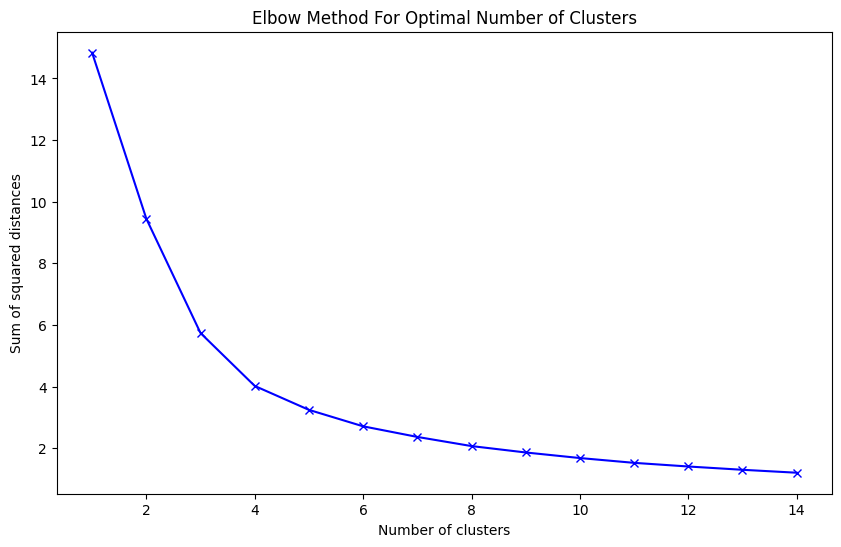

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducing the dimensions of the TF-IDF matrix
pca = PCA(n_components=2)  # You can adjust the number of components
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

# Elbow method with reduced dimensions
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf_matrix_reduced)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the elbow
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

In [14]:
from sklearn.cluster import KMeans
# Step 3: Applying K-Means Clustering
# We'll try with an arbitrary number of clusters, say 3, and adjust later if needed
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
print(tfidf_matrix.shape)
# Step 4: Analyze the result
clusters = km.labels_.tolist()

# Creating a DataFrame for better visualization
papers_df = pd.DataFrame({'Paper': range(len(list_keywords_papers)), 'Keywords': list_keywords_papers, 'Cluster': clusters})
papers_df

(1989, 1800)


/home/tenjin1/alfredo/corporatus/dashboard_db/dashboard-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Paper,Keywords,Cluster
0,0,"prediction performative, retraining, loops exp...",0
1,1,"oryzae genome, insufficient fungi, causes blas...",0
2,2,"blackness denmark, belonging dissertation, dec...",4
3,3,"editing rice, drought stress, traits gene, cri...",0
4,4,"biology tuberculosis, lipid inclusions, multid...",0
...,...,...,...
1984,1984,"premyelinating oligodendrocytes, alcohol withd...",0
1985,1985,"addiction substrate, 22 khz, ultrasonic vocali...",0
1986,1986,"reasoning children, implicatures basis, uttera...",0
1987,1987,"task rhythmic, electro encephalography, play p...",0


In [19]:
cluster_counts = papers_df.groupby('Cluster').count()
cluster_counts['Paper']

Cluster
0    1345
1     222
2     181
3     109
4     132
Name: Paper, dtype: int64

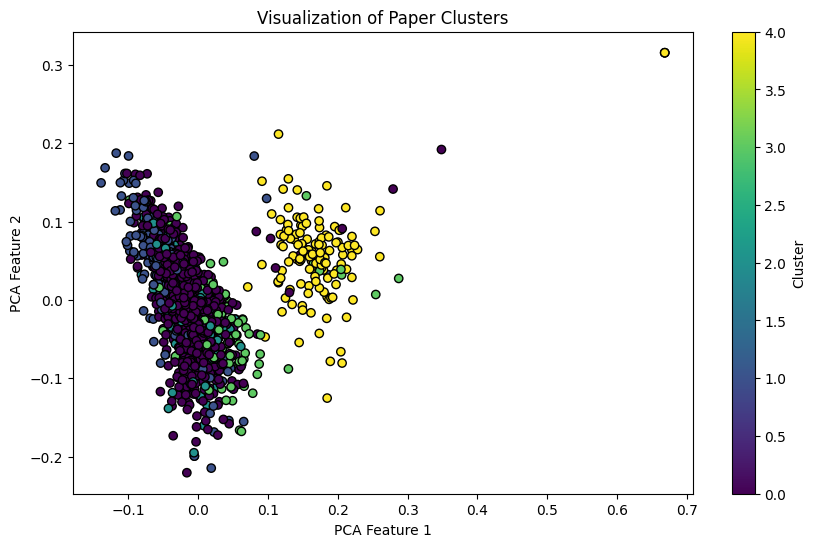

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducing the dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

# Scatter plot for the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k')

# Adding annotations
#for i, txt in enumerate(papers_df['Paper']):
#    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]))

plt.title('Visualization of Paper Clusters')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

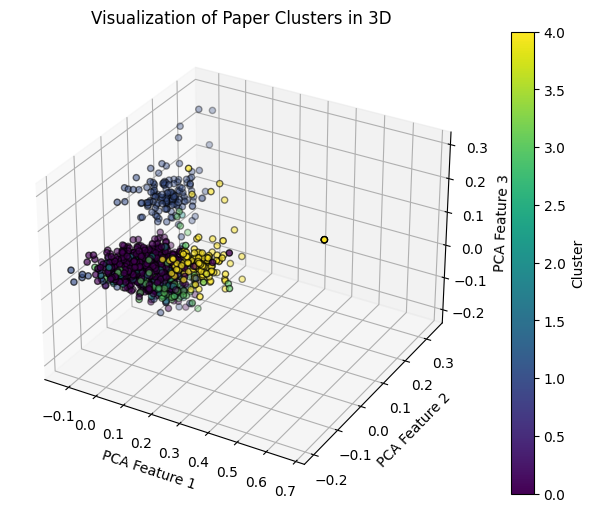

In [17]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reducing the dimensions for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(tfidf_matrix.toarray())

# Scatter plot for the clusters in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=clusters, cmap='viridis', marker='o', edgecolor='k')

# Adding annotations (you can uncomment this part if needed)
# for i, txt in enumerate(papers_df['Paper']):
#     ax.text(X_pca[i, 0], X_pca[i, 1], X_pca[i, 2], txt)

ax.set_title('Visualization of Paper Clusters in 3D')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
fig.colorbar(scatter, label='Cluster')
plt.show()

----

In [21]:
cluster_dict = {}
for cluster, keywords in papers_df.groupby('Cluster')['Keywords']:
    keyword_list = ', '.join(keywords).split(', ')
    cluster_dict[cluster] = keyword_list

import pickle
file_path = 'cluster_dict.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(cluster_dict, file)

In [22]:
file_path = 'cluster_dict.pkl'

# Load the 'cluster_dict' from the pickle file
with open(file_path, 'rb') as file:
    cluster_dict = pickle.load(file)

# Now, 'cluster_dict' contains the data from the pickle file
print(cluster_dict)

{0: ['prediction performative', 'retraining', 'loops explained', 'travel time', 'triggers', 'quantity change', 'navigation apps', 'discusses principles', 'cases ignoring', 'end identify', 'oryzae genome', 'insufficient fungi', 'causes blast', 'believe eccdnas', 'impacts agriculture', 'conserved', 'adapt tools', 'chapter motivations', 'experiencing pav', 'distinct distances', 'editing rice', 'drought stress', 'traits gene', 'crispr cas9', 'epfl10 lines', 'cyanogenic glucoside', 'clines securing', 'global calories', 'stomatal density', 'performance range', 'biology tuberculosis', 'lipid inclusions', 'multidrug resistant', 'metabolic processes', 'persistence ili', 'mortality rate', 'differences transcriptional', 'strict', 'launched host', 'uncover key', 'reproducibility interpretability', 'biomedical', 'recommendation named', 'tools support', 'source', 'factors essential', 'range data', 'pancreatic cancer', 'stability minimum', 'expand theme', 'plan developed', 'riyadh undesirable', 'appr

In [38]:
import pandas as pd
from keybert import KeyBERT

kw_extractor = KeyBERT('all-MiniLM-L6-v2')
cluster_keywords_keybert = {}

for cluster, group_df in papers_df.groupby('Cluster'):
    cluster_text = ' '.join(group_df['Keywords'])
    keywords = kw_extractor.extract_keywords(cluster_text, top_n=10)
    cluster_keywords_keybert[cluster] = {
        'keywords': [kw[0] for kw in keywords],
        'count': len(group_df)  # Add the count of elements in the cluster
    }

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda


In [39]:
cluster_keywords_keybert

{0: {'keywords': ['bioinformatics',
   'genomics',
   'bioengineered',
   'biochar',
   'genome',
   'biomarker',
   'genomes',
   'genomic',
   'bio',
   'transcriptomic'],
  'count': 1229},
 1: {'keywords': ['analyses',
   'retrieval',
   'structure',
   'bioactivity',
   'abstract',
   'structural',
   'biomolecular',
   'research',
   'organization',
   'analyze'],
  'count': 91},
 2: {'keywords': ['biophysical',
   'bioinformatic',
   'biosensors',
   'molecular',
   'nanoscale',
   'models',
   'biofims',
   'molecule',
   'classifier',
   'neurons'],
  'count': 114},
 3: {'keywords': ['analyzes',
   'frameworks',
   'modeling',
   'applications',
   'technologies',
   'approaches',
   'models',
   'computational',
   'software',
   'datasets'],
  'count': 170},
 4: {'keywords': ['dissertation',
   'ethnographic',
   'analyses',
   'explored',
   'examines',
   'explores',
   'typology',
   'study',
   'decolonization',
   'research'],
  'count': 119}}

Conclusion:

- Cluster 0 (1229 pdfs): This cluster is predominantly focused on **Biological Sciences**, specifically in the areas of genetics and bioengineering.

- Cluster 1 (91 pdfs): This cluster can be broadly categorized under **Biomolecular Research**.

- Cluster 2 (114 pdfs): This is primarily concerned with **Biophysical Sciences and Technology**.

- Cluster 3 (170 pdfs): This cluster falls into the realm of **Computational and Technological Sciences**.

- Cluster 4 (119 pdfs): This represents a focus on **Social Sciences and Humanities**.

---